In [42]:
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
from modeler.modeler import Modeler as m
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from transformer.adhoc_transforms import Adhoc as adhocs
from transformer.risk_transforms import Risk as risks
from transformer.analysis_transforms import Analysis as anas

import numpy as np
import matplotlib.pyplot as plt
import pickle
from functional.backtester import Backtester as b
from statistics import variance
import math

In [43]:
start_date = datetime(2020,1,1)
end_date = datetime(2023,1,1)

In [44]:
market = Market()
strats = ["rolling","window","spec"]

In [45]:
market.connect()
crypto = market.retrieve("crypto")
market.disconnect()

In [46]:
crypto = p.column_date_processing(crypto)
current = pd.read_csv("./csv_files/prices/BTC-USD.csv")
current["ticker"] = "BTC"
current = p.column_date_processing(current)
crypto = pd.concat([crypto,current])

In [47]:
tyields = adhocs.tyields()
bench_returns = adhocs.spy_bench()

In [48]:
trades = []
for strat in strats:
    speculation_db = ADatabase(f"btc_class_{strat}")
    speculation_db.connect()
    stuff = speculation_db.retrieve("trades")
    stuff["strat"] = strat
    trades.append(stuff)
    speculation_db.disconnect()
t = pd.concat(trades)

In [49]:
reqs = [0.05]
signals = [0.05]
values = [True]
classifications = [False]
ceilings = [True,False]
floors = [True,False]
hedges = [False]
parameters = []
positions = 1
training_year = 4
for strat in strats:
    for value in values:
        for classification in classifications:
            for ceiling in ceilings:
                for floor in floors:
                    for hedge in hedges:
                        for signal in signals:
                            for req in reqs:
                                parameter = {"value":value
                                             ,"classification":classification
                                             ,"ceiling":ceiling
                                             ,"floor":floor
                                             ,"hedge":hedge
                                             ,"signal":signal
                                             ,"req":req
                                             ,"training_years":training_year
                                            ,"strat":strat
                                            }
                                parameters.append(parameter)

In [50]:
analysis = []
indexer = list(parameters[0].keys())
for parameter in parameters:
    try:
        ledger = t.sort_values(["year","week"]).copy()
        for key in parameter.keys():
            ledger = ledger[ledger[key]==parameter[key]]
        if ledger.index.size > 0:
            cumulative = anas.trade_analysis(indexer,ledger,positions,parameter,tyields,bench_returns)
            analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
    except Exception as e:
        print(str(e))
        continue
a = pd.DataFrame(analysis)

In [51]:
portfolio

position,year,week,0
0,2020.0,4.0,1.011451
1,2020.0,5.0,1.000861
2,2020.0,8.0,0.981639
3,2020.0,9.0,0.990547
4,2020.0,10.0,1.012698
...,...,...,...
100,2022.0,45.0,1.008782
101,2022.0,46.0,0.989842
102,2022.0,48.0,1.046938
103,2022.0,50.0,0.987922


In [52]:
a

,value,classification,ceiling,floor,hedge,signal,req,training_years,strat,pv,beta,rrr,sharpe
40,True,False,True,True,False,0.05,0.05,4,rolling,1.014350,0.872815,1.273771,-0.043595
40,True,False,True,False,False,0.05,0.05,4,rolling,0.895794,0.839061,1.265210,-0.186644
46,True,False,False,True,False,0.05,0.05,4,rolling,0.994081,1.151575,1.428023,-0.050642
46,True,False,False,False,False,0.05,0.05,4,rolling,0.865175,1.056790,1.397106,-0.177164
46,True,False,True,True,False,0.05,0.05,4,window,1.019716,1.135903,1.422911,-0.028773
46,True,False,True,False,False,0.05,0.05,4,window,0.710814,1.105604,1.413028,-0.308958
46,True,False,False,True,False,0.05,0.05,4,window,1.019716,1.135903,1.422911,-0.028773
46,True,False,False,False,False,0.05,0.05,4,window,0.710814,1.105604,1.413028,-0.308958
104,True,False,True,True,False,0.05,0.05,4,spec,1.039428,0.869632,1.195103,-0.014917
104,True,False,True,False,False,0.05,0.05,4,spec,0.339807,1.427436,1.286637,-0.499212


In [53]:
a.sort_values("pv",ascending=False).groupby("strat").first().reset_index().sort_values("pv")

,strat,value,classification,ceiling,floor,hedge,signal,req,training_years,pv,beta,rrr,sharpe
0,rolling,True,False,True,True,False,0.05,0.05,4,1.014350,0.872815,1.273771,-0.043595
2,window,True,False,True,True,False,0.05,0.05,4,1.019716,1.135903,1.422911,-0.028773
1,spec,True,False,True,True,False,0.05,0.05,4,1.039428,0.869632,1.195103,-0.014917


In [54]:
top = a.sort_values("pv",ascending=False).iloc[0]
analysis = t
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
ledger = analysis[["year","week","ticker","delta","actual_returns","position"]]

In [55]:
ledger.sort_values(["year","week","delta"]).head(30)

,year,week,ticker,delta,actual_returns,position
1260,2020.0,4.0,BTC,0.019650,0.965646,0
140,2020.0,4.0,BTC,0.029187,1.034354,0
700,2020.0,4.0,BTC,0.075379,1.034354,0
1261,2020.0,5.0,BTC,0.018398,1.000861,0
141,2020.0,5.0,BTC,0.035126,1.000861,0
701,2020.0,5.0,BTC,0.098026,1.000861,0
142,2020.0,8.0,BTC,0.040554,0.950000,0
1262,2020.0,8.0,BTC,0.053466,0.950000,0
702,2020.0,8.0,BTC,0.152727,1.044918,0
143,2020.0,9.0,BTC,0.024384,0.950000,0


In [56]:
metric = "position"

In [57]:
portfolio = ledger.pivot_table(index=["year","week"],columns=metric,values="actual_returns").fillna(1).reset_index()
portfolio.reset_index()

position,index,year,week,0
0,0,2020.0,4.0,1.011451
1,1,2020.0,5.0,1.000861
2,2,2020.0,8.0,0.981639
3,3,2020.0,9.0,0.990547
4,4,2020.0,10.0,1.012698
...,...,...,...,...
100,100,2022.0,45.0,1.008782
101,101,2022.0,46.0,0.989842
102,102,2022.0,48.0,1.046938
103,103,2022.0,50.0,0.987922


In [58]:
counted_columns = [x for x in range(positions)]
cumulative = portfolio[[i for i in counted_columns]].cumprod()
cumulative["date_string"] = [f'{int(row[1]["year"])}-W{int(row[1]["week"])}' for row in portfolio.iterrows()]
cumulative["date"] = [datetime.strptime(x + '-1', '%G-W%V-%u') for x in cumulative["date_string"]]
cumulative["pv"] = [sum([row[1][column] * 1/positions for column in counted_columns]) for row in cumulative.iterrows()]
cumulative = cumulative.merge(bench_returns[["date","adjclose"]],on="date",how="left")
cumulative = cumulative.fillna(method="bfill").dropna()
cumulative["bench"] = [1+ (row[1]["adjclose"] - cumulative["adjclose"].iloc[0]) / cumulative["adjclose"].iloc[0] for row in cumulative.iterrows()]

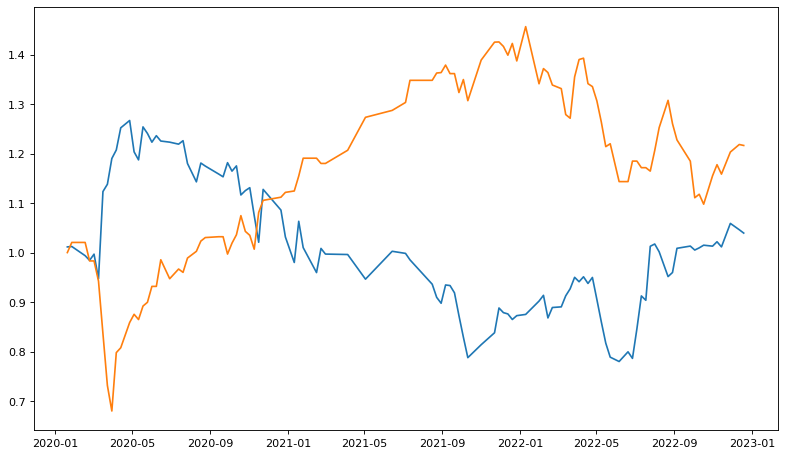

In [59]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])